<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/2FFNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

for i in range(10):
    batch = train_generator.next()

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model FFNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
hidden_neurons1 = 548
hidden_neurons2 = 74

model2f = Sequential()
model2f.add(Flatten(input_shape=(52, 78, 1)))
model2f.add(Dense(hidden_neurons1, activation='relu'))
model2f.add(Dense(hidden_neurons2, activation='relu'))
model2f.add(Dense(10, activation='softmax'))

model2f.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Mendapatkan bobot dari model
weights = []
for layer in model2f.layers:
    weights.append(layer.get_weights())

print("Bobot dari model:")
for i, layer_weights in enumerate(weights):
    print("Layer", i+1)
    for j, w in enumerate(layer_weights):
        print("  Bobot {}: {}".format(j+1, w.shape))

Bobot dari model:
Layer 1
Layer 2
  Bobot 1: (4056, 548)
  Bobot 2: (548,)
Layer 3
  Bobot 1: (548, 74)
  Bobot 2: (74,)
Layer 4
  Bobot 1: (74, 10)
  Bobot 2: (10,)


In [9]:
model2f.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4056)              0         
                                                                 
 dense (Dense)               (None, 548)               2223236   
                                                                 
 dense_1 (Dense)             (None, 74)                40626     
                                                                 
 dense_2 (Dense)             (None, 10)                750       
                                                                 
Total params: 2264612 (8.64 MB)
Trainable params: 2264612 (8.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
history = model2f.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 8s 229ms/step - loss: 2.0458 - accuracy: 0.2944
Epoch 2/20
28/28 [==============================] - 5s 174ms/step - loss: 1.9448 - accuracy: 0.3585
Epoch 3/20
28/28 [==============================] - 3s 98ms/step - loss: 1.9288 - accuracy: 0.3607
Epoch 4/20
28/28 [==============================] - 3s 110ms/step - loss: 1.9048 - accuracy: 0.3749
Epoch 5/20
28/28 [==============================] - 3s 96ms/step - loss: 1.8785 - accuracy: 0.3619
Epoch 6/20
28/28 [==============================] - 2s 78ms/step - loss: 1.8546 - accuracy: 0.3812
Epoch 7/20
28/28 [==============================] - 2s 78ms/step - loss: 1.7916 - accuracy: 0.4101
Epoch 8/20
28/28 [==============================] - 2s 78ms/step - loss: 1.7933 - accuracy: 0.3908
Epoch 9/20
28/28 [==============================] - 2s 88ms/step - loss: 1.7944 - accuracy: 0.3993
Epoch 10/20
28/28 [==============================] - 3s 117ms/step - loss: 1.7889 - accuracy: 0.3953
Epoch

In [11]:
# Loop melalui semua layer dalam model yang sudah dimuat
for layer in model2f.layers:
    # Periksa apakah layer adalah lapisan Dense
    if isinstance(layer, Dense):
        # Peroleh bobot dari lapisan
        weights = layer.get_weights()
        # Cetak informasi tentang bobot
        print(f"Layer Name: {layer.name}")
        print("Weight Matrix Shape:", weights[0].shape)  # Ukuran matriks bobot
        print("Weight Matrix:")
        print(weights[0])  # Bobot
        print("Bias Vector Shape:", weights[1].shape)    # Ukuran vektor bias
        print("Bias Vector:")
        print(weights[1])    # Bias
        print("-----------------------------------")

Layer Name: dense
Weight Matrix Shape: (4056, 548)
Weight Matrix:
[[-0.00473165 -0.02579702 -0.01263193 ... -0.00287232 -0.01386226
  -0.03205138]
 [ 0.03259091  0.03259996 -0.00797483 ...  0.00433692 -0.0083041
  -0.019952  ]
 [-0.01286026  0.02293409  0.0043934  ... -0.00046754 -0.02176013
   0.03353382]
 ...
 [ 0.02445468  0.02351471  0.02901611 ... -0.02072095 -0.00790881
   0.01919079]
 [-0.02871225 -0.03028563 -0.00927439 ... -0.03365218 -0.02060754
  -0.03355066]
 [ 0.01535909 -0.00035733  0.01544275 ... -0.0011031   0.02030904
  -0.0010042 ]]
Bias Vector Shape: (548,)
Bias Vector:
[ 0.00000000e+00  2.78766034e-03 -2.03003146e-04 -1.77135644e-03
  4.06525447e-04  1.66289206e-03  3.72845156e-04 -1.00459007e-03
 -5.66540948e-05  5.43305476e-04  2.41529822e-04  1.58948882e-03
  7.33209366e-04 -1.82135857e-03 -2.12257073e-04  2.30090955e-04
  1.27100083e-03 -9.90340603e-04  2.72421719e-04 -7.62392709e-04
  1.08653586e-03  1.90253672e-06 -4.42197052e-04 -6.01998821e-04
 -1.27726351e-

#Matriks Konfusi

7/7 [==============================] - 0s 33ms/step


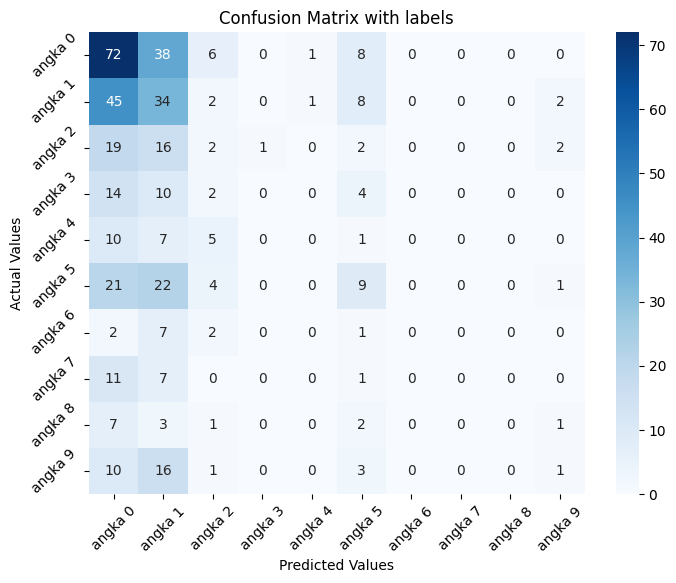

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model2f, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [15]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.2651685393258427
